# Trist'n Joseph - IST664 - Homework 1

In [1]:
# Do a comparion of POS against financial times vs books

## Set Up

In [2]:
import requests
from bs4 import BeautifulSoup

from datetime import datetime

import pandas as pd
import numpy as np

import string
import re
import nltk
from nltk import FreqDist
from nltk.collocations import *
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import treebank

from textblob import TextBlob

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Extraction and Loading

### Collecting data from MarketWatch

In [3]:
# collecting recent articles 
def get_articles(company_ticker, number_of_articles=50):
    """
    """
    company_ticker = company_ticker.lower()
    company_ticker_U = company_ticker.upper()
    
    print('Retrieving the', number_of_articles, 'most recent articles for ticker symbol', company_ticker_U, 'on MarketWatch.')
    
    # creating the link to request
    query_link = 'https://www.marketwatch.com/search?q=' + str(company_ticker) + '&m=Keyword&rpp=' + str(number_of_articles) + '&mp=0&bd=false&rs=false'
    
    # requesting data
    all_articles = requests.get(query_link)
    
    # parsing the data as html
    all_articles_soup =  BeautifulSoup(all_articles.content, 'html.parser')
    
    # extracting the urls
    url_vector = []
    
    # -- the location of the urls
    searchresults = all_articles_soup.find_all('div', 'searchresult')
    for item in searchresults:
        current_url = str(item.find('a')['href'])
        
        # -- adding `http` since not all urls are formatted correctly 
        if not (current_url.startswith('http')):
            current_url = 'http://www.marketwatch.com' + current_url
        
        url_vector.append(current_url)
        
    # extracting the dates and datetimes
    datetime_vector = []
    date_vector = []
    
    # -- the location of the dates
    times = all_articles_soup.find_all('div', 'deemphasized')
    for item in times:
        current_time = str(item.find('span').text)
        
        # -- cleaning how MarketWatch reports times
        if 'Today' in current_time:

            string_to_remove = current_time[0:current_time.find('Today') + 5]
            print("Removing '" + string_to_remove + "' because it is an invalid time structure...")

            current_time = current_time.replace(string_to_remove, '')

        if 'p.m.' in current_time:
            current_time = current_time.replace('p.m.', 'PM')
        else:
            current_time = current_time.replace('a.m.', 'AM')

        if 'March' in current_time:
            current_time = current_time.replace('March', 'Mar.')
            
        if 'April' in current_time:
            current_time = current_time.replace('April', 'Apr.')
            
        if 'May' in current_time:
            current_time = current_time.replace('May', 'May.')
            
        if 'July' in current_time:
            current_time = current_time.replace('July', 'Jul.')

        if 'June' in current_time:
            current_time = current_time.replace('June', 'Jun.')
        
        if 'Sept' in current_time:
            current_time = current_time.replace('Sept.', 'Sep.')

        current_datetime = datetime.strptime(current_time, '%I:%M %p %b. %d, %Y')
        current_date = current_datetime.date()    


        datetime_vector.append(current_datetime)
        date_vector.append(current_date)
    
    # extracting the titles and the bodies from each article
    title_vector = []
    body_vector = []
    collected_webpages = 0
    for webpage in url_vector:
        article = requests.get(webpage)
        article_soup = BeautifulSoup(article.content, 'html.parser')

        current_article_title = article_soup.find('title').text
        current_article_body = article_soup.find('p').text

        title_vector.append(current_article_title)
        body_vector.append(current_article_body)

        collected_webpages += 1

        print('Collected ' + str(collected_webpages) + '/' + str(len(url_vector)) + ' articles...')
    
    # creating a dataframe with all the collected information
    articles_df = pd.DataFrame(
        list(zip(url_vector, datetime_vector, date_vector, title_vector, body_vector)),
        columns=['url', 'date_time', 'date', 'title', 'body']
    )
    
    print('Done. Collected all articles.')
    
    return articles_df

In [4]:
def collapse_articles_from_df(df, *args):
    """
    """
    columns = []
    ol = []
    
    for arg in args:
        columns.append(arg)        
    
    for i in range(0, len(df)):
        for col_name in columns:
            ol.append(df[col_name][i])
    
    return ol

def ug__regex_pattern_match(words):
    """
    """    
    ug__regex_pattern = re.compile('^[^a-z]+$')
    if (ug__regex_pattern.match(words)):
        return True
    else:
        return False
    
def bg__regex_tokenize(words):
    """
    """  
    pattern = r''' (?x)
        (?:[A-Z]\.)+
        | (?:--+)
        | \w+(?:-\w+)*        
        | \$?\d+(?:\.\d+)?%?
        | ['\".?!,:;/]+
        | [][.,;â€â€™?():-_%#â€™]
        '''
    
    tokenized_text = nltk.regexp_tokenize(words, pattern)
    
    return tokenized_text

In [5]:
def clean_text_data(raw_text):
    """
    """
    porter = nltk.PorterStemmer()
    nltkstopwords = nltk.corpus.stopwords.words('english')
    all_stopwords = nltkstopwords + ["MarketWatch", "marketwatch", "mw", "zachs", "zacks", "barron"]
    
    # need to develop different methods for unigrams vs bigrams etc
    # -- unigram
    ug__text_tokenized = nltk.word_tokenize(raw_text)
    ug__text_words = [w.lower() for w in ug__text_tokenized]
    ug__text_words = [porter.stem(word) for word in ug__text_words]
    ug__text_words_filtered = [w for w in ug__text_words if not ug__regex_pattern_match(w)]
    ug__text_words_filtered = [w for w in ug__text_words_filtered if not w in all_stopwords]
    ug__word_frequency_distribution = FreqDist(ug__text_words_filtered)
    
    # -- bigram
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bg__text_tokenized = bg__regex_tokenize(raw_text)
    bg__text_words = [w for w in bg__text_tokenized]
    
    # ---- frequencies
    bg__fnder_freq = BigramCollocationFinder.from_words(bg__text_words)
    bg__fnder_freq.apply_word_filter(ug__regex_pattern_match)
    bg__fnder_freq.apply_word_filter(lambda w: w in all_stopwords)
    bg__scored_freq = bg__fnder_freq.score_ngrams(bigram_measures.raw_freq)
    
    # ---- PMI
    bg__fnder_pmi = BigramCollocationFinder.from_words(bg__text_words)
    bg__fnder_pmi.apply_freq_filter(5)
    bg__scored_pmi = bg__fnder_pmi.score_ngrams(bigram_measures.pmi)
    
    # -- trigram
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    tg__text_tokenized = bg__regex_tokenize(raw_text)
    tg__text_words = [w for w in tg__text_tokenized]
    
    # ---- frequencies
    tg__fnder_freq = TrigramCollocationFinder.from_words(tg__text_words)
    tg__fnder_freq.apply_word_filter(ug__regex_pattern_match)
    tg__fnder_freq.apply_word_filter(lambda w: w in all_stopwords)
    tg__scored_freq = tg__fnder_freq.score_ngrams(trigram_measures.raw_freq)
    
    # ---- PMI
    tg__fnder_pmi = TrigramCollocationFinder.from_words(tg__text_words)
    tg__fnder_pmi.apply_freq_filter(5)
    tg__scored_pmi = tg__fnder_pmi.score_ngrams(trigram_measures.pmi)
    
    # -- output
    od  = {
        'unigrams': {
            'frequency': ug__word_frequency_distribution            
        },
        'bigrams': {
            'frequency': bg__scored_freq,
            'pmi': bg__scored_pmi            
        },
        'trigrams': {
            'frequency': tg__scored_freq,
            'pmi': tg__scored_pmi            
        }
    }
    return od

In [6]:
def tag_POS(tagging_text):
    """
    """
    # Separating the data into training and test data
    treebank_text = treebank.raw()
    treebank_tokens = treebank.words()
    treebank_tagged_words = treebank.tagged_words()
    treebank_tagged = treebank.tagged_sents()
    
    t0 = nltk.DefaultTagger('NN')
    t1 = nltk.UnigramTagger(treebank_tagged, backoff=t0)
    t2 = nltk.BigramTagger(treebank_tagged, backoff=t1)
    
    raw_text_split = nltk.sent_tokenize(tagging_text)
    text_tokenized = [bg__regex_tokenize(word) for word in raw_text_split]
    
    tagged_text = [t2.tag(tokens) for tokens in text_tokenized]
    
    tagged_text_flat = [pair for tagging_text in tagged_text for pair in tagging_text]
    
    return tagged_text_flat

In [7]:
recent_articles_df = get_articles('tsla', number_of_articles=500)

Retrieving the 500 most recent articles for ticker symbol TSLA on MarketWatch.
Removing '11:08 a.m.  Today' because it is an invalid time structure...
Removing '10:53 a.m.  Today' because it is an invalid time structure...
Removing '10:31 a.m.  Today' because it is an invalid time structure...
Removing '10:12 a.m.  Today' because it is an invalid time structure...
Removing '9:44 a.m.  Today' because it is an invalid time structure...
Removing '9:27 a.m.  Today' because it is an invalid time structure...
Removing '9:00 a.m.  Today' because it is an invalid time structure...
Collected 1/500 articles...
Collected 2/500 articles...
Collected 3/500 articles...
Collected 4/500 articles...
Collected 5/500 articles...
Collected 6/500 articles...
Collected 7/500 articles...
Collected 8/500 articles...
Collected 9/500 articles...
Collected 10/500 articles...
Collected 11/500 articles...
Collected 12/500 articles...
Collected 13/500 articles...
Collected 14/500 articles...
Collected 15/500 articl

In [8]:
collapsed_articles = collapse_articles_from_df(recent_articles_df, 'title', 'body')

In [9]:
raw_article_text = ' '.join([str(elem) for elem in collapsed_articles])
# text_file = open("C:/Users/trist/OneDrive/Desktop/Trist'n/School/Syracuse University/Q4 2021/IST664/Assignments/Homework 1/article_text.txt", "w")
# n = text_file.write(raw_article_text)
# text_file.close()

In [10]:
article_analysis_output = clean_text_data(raw_article_text)
for i in article_analysis_output:
    print(i)

unigrams
bigrams
trigrams


In [11]:
article_frequent_unigrams = article_analysis_output['unigrams']['frequency'].most_common(50)
for i in article_frequent_unigrams:
    print(i)

('stock', 569)
('tesla', 398)
('market', 230)
('compani', 200)
("'s", 190)
('motor', 179)
('trade', 154)
('rise', 151)
('inc.', 135)
('co.', 129)
('industri', 125)
('day', 124)
('fall', 122)
('high', 120)
('vehicl', 115)
('share', 114)
('ev', 110)
('nio', 110)
('electr', 109)
('investor', 108)
('ford', 103)
('close', 102)
('index', 100)
('car', 99)
('dow', 99)
('gener', 97)
('jone', 94)
('averag', 94)
('thi', 93)
('session', 89)
('prove', 89)
('52-week', 89)
('ha', 88)
('all-around', 88)
('djia', 88)
('maker', 85)
('wa', 81)
('adr', 80)
('new', 74)
('group', 73)
('musk', 71)
('workhors', 69)
('p', 63)
('could', 63)
('whi', 62)
('elon', 60)
('auto', 60)
('short', 59)
('outperform', 59)
('electric-vehicl', 55)


In [12]:
for score in article_analysis_output['bigrams']['frequency'][0:51]:
    print(score)

(('stock', 'market'), 0.0032648960884033404)
(('Dow', 'Jones'), 0.0029195705405914486)
(('Industrial', 'Average'), 0.0029195705405914486)
(('Jones', 'Industrial'), 0.0029195705405914486)
(('General', 'Motors'), 0.002793997614114397)
(('52-week', 'high'), 0.002762604382495134)
(('trading', 'session'), 0.002762604382495134)
(('Ford', 'Motor'), 0.0025428517611602937)
(('Group', 'Inc'), 0.0021661329817291393)
(('Workhorse', 'Group'), 0.0021661329817291393)
(('Motors', 'Co'), 0.0020719532868713505)
(('Motor', 'Co'), 0.001977773592013562)
(('Elon', 'Musk'), 0.0018835938971557733)
(('Tesla', 'Stock'), 0.0017580209706787218)
(('company', 'achieved'), 0.0015382683493438815)
(('Composite', 'Index'), 0.00141269542286683)
(('consecutive', 'day'), 0.00141269542286683)
(('company', 'reached'), 0.0012243360331512525)
(('electric', 'vehicles'), 0.0011929428015319897)
(('electric', 'vehicle'), 0.001067369875054938)
(('trading', 'day'), 0.001067369875054938)
(('strong', 'trading'), 0.0010359766434356753

In [13]:
for score in article_analysis_output['bigrams']['pmi'][0:51]:
    print(score)

(('Blue', 'Origin'), 12.374224426123732)
(('article', 'originally'), 12.374224426123732)
(('Plug', 'Power'), 12.151832004787284)
(('Self', 'Driving'), 12.151832004787284)
(('Federal', 'Reserve'), 11.959186926844886)
(('Goldman', 'Sachs'), 11.789261925402577)
(('originally', 'appeared'), 11.526227519568781)
(('Jeff', 'Bezos'), 11.49975530820759)
(('semiconductor', 'shortage'), 11.374224426123732)
(('Faraday', 'Future'), 11.258747208703795)
(('Wall', 'Street'), 11.044916800870773)
(('two-day', 'losing'), 11.01432848103735)
(('March', '15th'), 10.871724085594547)
(('$1', 'Trillion'), 10.789261925402577)
(('Model', 'Y'), 10.7112594134013)
(('autonomous', 'driving'), 10.669680309649902)
(('three-day', 'winning'), 10.637258831957524)
(('$1', 'trillion'), 10.59661684746018)
(('Li', 'Auto'), 10.585728531317443)
(('January', '11th'), 10.499755308207591)
(('April', '6th'), 10.435624970787876)
(('losing', 'streak'), 10.315330737070163)
(('second-quarter', 'earnings'), 10.315330737070163)
(('fall'

In [14]:
for score in article_analysis_output['trigrams']['frequency'][0:51]:
    print(score)

(('Dow', 'Jones', 'Industrial'), 0.0029195705405914486)
(('Jones', 'Industrial', 'Average'), 0.0029195705405914486)
(('Workhorse', 'Group', 'Inc'), 0.0021661329817291393)
(('General', 'Motors', 'Co'), 0.0020719532868713505)
(('Ford', 'Motor', 'Co'), 0.001977773592013562)
(('strong', 'trading', 'day'), 0.0010359766434356753)
(('second', 'consecutive', 'day'), 0.0007848307904815722)
(('Tesla', 'Stock', 'Is'), 0.0005022917059082062)
(('stock', 'outperforms', 'market'), 0.0005022917059082062)
(('all-around', 'positive', 'trading'), 0.00047089847428894333)
(('positive', 'trading', 'session'), 0.00047089847428894333)
(('stock', 'outperforms', 'competitors'), 0.00047089847428894333)
(('all-around', 'great', 'trading'), 0.00043950524266968044)
(('great', 'trading', 'session'), 0.00043950524266968044)
(('third', 'consecutive', 'day'), 0.00043950524266968044)
(('all-around', 'mixed', 'trading'), 0.00040811201105041755)
(('mixed', 'trading', 'session'), 0.00040811201105041755)
(('all-around', 'fa

In [15]:
for score in article_analysis_output['trigrams']['pmi'][0:51]:
    print(score)

(('article', 'originally', 'appeared'), 24.16348635152631)
(('two-day', 'losing', 'streak'), 21.329659218107516)
(('This', 'article', 'originally'), 21.224886896190455)
(('three-day', 'winning', 'streak'), 20.952589569027687)
(('Model', 'S', 'Plaid'), 19.257664814907717)
(('competitors', 'despite', 'losses'), 18.29723774041513)
(('originally', 'appeared', 'on'), 17.867028944155066)
(('Composite', 'Index', 'COMP'), 17.794252541860587)
(('NASDAQ', 'Composite', 'Index'), 17.794252541860587)
(('S', 'P', '500'), 17.74554312107205)
(('outperforms', 'competitors', 'despite'), 17.685803028332785)
(('500', 'Index', 'SPX'), 17.379215042581745)
(('CEO', 'Elon', 'Musk'), 17.257664814907717)
(('third', 'consecutive', 'day'), 17.212772319845637)
(('on', 'March', '15th'), 17.21252551018083)
(('a', 'two-day', 'losing'), 17.19215569435758)
(('second', 'consecutive', 'day'), 16.97527300611898)
(('on', 'January', '11th'), 16.840556732793875)
(('Industrial', 'Average', 'DJIA'), 16.840056231473717)
(('P', 

In [16]:
article_POS = tag_POS(raw_article_text)

In [17]:
for pos in article_POS[:50]:
    print(pos)

('Tesla-Hertz', 'NN')
('Deal', 'NN')
('Is', 'VBZ')
('Great', 'NNP')
('News', 'NNP')
('for', 'IN')
('Carvana', 'NN')
('Stock', 'NNP')
('MarketWatch', 'NN')
('The', 'DT')
('move', 'NN')
('by', 'IN')
('Hertz', 'NN')
('Global', 'NN')
('to', 'TO')
('bulk', 'NN')
('up', 'IN')
('its', 'PRP$')
('global', 'JJ')
('fleet', 'NN')
('of', 'IN')
('rentals', 'NNS')
('with', 'IN')
('100', 'CD')
(',', ',')
('000', 'NN')
('electric', 'JJ')
('vehicles', 'NNS')
('from', 'IN')
('Tesla', 'NN')
('is', 'VBZ')
('great', 'JJ')
('news', 'NN')
('for', 'IN')
('Carvana', 'NN')
(',', ',')
('which', 'WDT')
('will', 'MD')
('work', 'VB')
('with', 'IN')
('Hertz', 'NN')
('to', 'TO')
('dispose', 'NN')
('of', 'IN')
('its', 'PRP$')
('unwanted', 'JJ')
('cars', 'NNS')
('.', '.')
('Tesla', 'NN')
('Bulls', 'NN')


In [18]:
# use the first letter of the POS tag to get classes of tags
articles_tag_classes_fd = nltk.FreqDist(tag[0] for (word, tag) in article_POS)
for tag, freq in articles_tag_classes_fd.most_common():
    print(tag, freq)

N 14114
V 2708
. 2486
I 2474
D 2137
C 1669
J 1441
, 1357
T 807
P 731
R 668
W 469
- 347
M 211
' 152
: 41
E 33
L 9


Text(0.5, 1.0, 'Distribution of General Part Of Speech, Stock Articles')

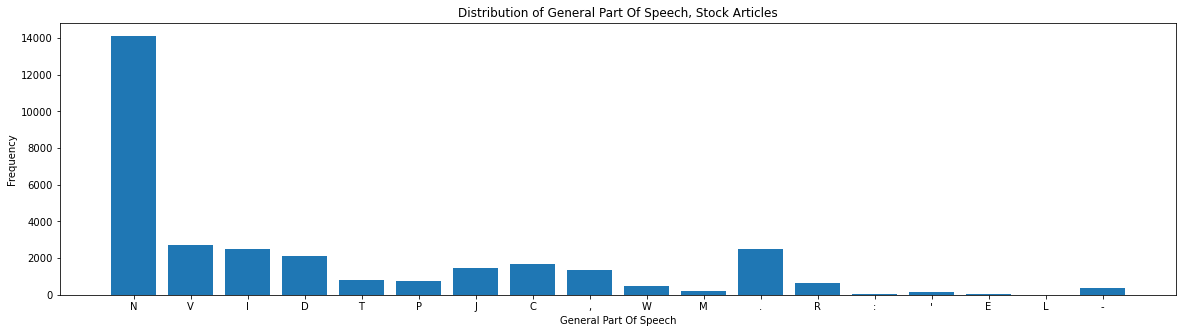

In [19]:
fig = plt.figure(figsize = (20, 5))
plt.bar(articles_tag_classes_fd.keys(), articles_tag_classes_fd.values())
plt.ylabel('Frequency')
plt.xlabel('General Part Of Speech')
plt.title('Distribution of General Part Of Speech, Stock Articles')

### Loading `Hamlet` from nltk 

In [20]:
hamlet_text = nltk.corpus.gutenberg.raw(nltk.corpus.gutenberg.fileids( )[15])
hamlet_tokens = nltk.word_tokenize(hamlet_text)

hamlet_words = [w.lower() for w in hamlet_tokens]
print(len(hamlet_words))
print(hamlet_words[ :50])

36372
['[', 'the', 'tragedie', 'of', 'hamlet', 'by', 'william', 'shakespeare', '1599', ']', 'actus', 'primus', '.', 'scoena', 'prima', '.', 'enter', 'barnardo', 'and', 'francisco', 'two', 'centinels', '.', 'barnardo', '.', 'who', "'s", 'there', '?', 'fran', '.', 'nay', 'answer', 'me', ':', 'stand', '&', 'vnfold', 'your', 'selfe', 'bar', '.', 'long', 'liue', 'the', 'king', 'fran', '.', 'barnardo', '?']


In [21]:
hamlet_analysis_output = clean_text_data(hamlet_text)

In [22]:
hamlet_frequent_unigrams = hamlet_analysis_output['unigrams']['frequency'].most_common(50)
for i in hamlet_frequent_unigrams:
    print(i)

('thi', 365)
('ham', 337)
('hi', 285)
('lord', 216)
("'d", 200)
('king', 180)
('haue', 175)
('come', 128)
("'s", 119)
('hamlet', 107)
('let', 107)
('shall', 107)
('thou', 104)
('good', 98)
('hor', 95)
('enter', 86)
('wa', 85)
('like', 82)
('oh', 81)
('make', 74)
('know', 74)
('loue', 71)
('well', 70)
('father', 70)
('doe', 69)
('would', 68)
('self', 66)
('giue', 66)
('may', 65)
('sir', 65)
('speak', 64)
('qu', 62)
("'t", 61)
('vs', 61)
('veri', 60)
('whi', 60)
('laer', 60)
('thee', 58)
('say', 58)
('ile', 58)
('must', 58)
('hath', 57)
('oph', 56)
('think', 54)
('one', 54)
('heauen', 53)
('time', 51)
('man', 51)
('vpon', 50)
('see', 50)


In [23]:
for score in hamlet_analysis_output['bigrams']['frequency'][0:51]:
    print(score)

(('Lord', 'Ham'), 0.0011856642414443546)
(('My', 'Lord'), 0.0007814605227701428)
(('Enter', 'King'), 0.00032336297493936947)
(('haue', 'seene'), 0.00029641606036108866)
(('And', 'let'), 0.00026946914578280785)
(('Enter', 'Hamlet'), 0.00026946914578280785)
(('Lord', 'Hamlet'), 0.00026946914578280785)
(('good', 'Lord'), 0.00024252223120452707)
(('st', 'thou'), 0.00024252223120452707)
(('Enter', 'Polonius'), 0.0002155753166262463)
(('Fathers', 'death'), 0.0002155753166262463)
(('Lord', 'Polon'), 0.0002155753166262463)
(('thou', 'hast'), 0.0002155753166262463)
(('If', 'thou'), 0.00018862840204796551)
(('Ile', 'haue'), 0.00018862840204796551)
(('The', 'King'), 0.00018862840204796551)
(('To', 'giue'), 0.00016168148746968473)
(('haue', 'heard'), 0.00016168148746968473)
(('mine', 'owne'), 0.00016168148746968473)
(('And', 'thus'), 0.00013473457289140393)
(('Enter', 'Horatio'), 0.00013473457289140393)
(('Hamlet', 'Ham'), 0.00013473457289140393)
(('What', 'would'), 0.00013473457289140393)
(('You'

In [24]:
for score in hamlet_analysis_output['bigrams']['pmi'][0:51]:
    print(score)

(('any', 'thing'), 8.770129444447187)
(('Fathers', 'death'), 8.761667865698993)
(('set', 'downe'), 8.479080662443797)
(('our', 'selues'), 8.296877331223046)
(('wilt', 'thou'), 7.962289664364221)
(('thou', 'art'), 7.792364662921907)
(('Enter', 'Polonius'), 7.500040281079444)
(('mine', 'owne'), 7.4527345663010856)
(('!', 'Oh'), 7.166058120778326)
(('your', 'Lordship'), 7.052299830096814)
(('haue', 'seene'), 6.986107026220207)
(('st', 'thou'), 6.952305575791598)
(('thou', 'hast'), 6.939921851335766)
(('so', 'farre'), 6.736576884736161)
(('haue', 'heard'), 6.626211081133823)
(('sent', 'for'), 6.556248522966255)
(('How', 'now'), 6.480622827252201)
(('put', 'on'), 6.429650953188043)
(('no', 'more'), 6.384149150289607)
(('too', 'much'), 6.327771339168832)
(('finde', 'him'), 6.3252753263647605)
(('her', 'owne'), 6.318433474589494)
(('My', 'Lord'), 6.250312996547505)
(('You', 'must'), 6.188565520187895)
(('they', 'say'), 6.135126261226436)
(('No', 'more'), 6.0882739152385525)
(('beseech', 'you'

In [25]:
for score in hamlet_analysis_output['trigrams']['frequency'][0:51]:
    print(score)

(('And', 'let', 'vs'), 5.3893829156561574e-05)
(('Dost', 'thou', 'heare'), 5.3893829156561574e-05)
(('Father', 'much', 'offended'), 5.3893829156561574e-05)
(('If', 'thou', 'hast'), 5.3893829156561574e-05)
(('Ile', 'follow', 'thee'), 5.3893829156561574e-05)
(('Oh', 'good', 'Horatio'), 5.3893829156561574e-05)
(('The', 'rugged', 'Pyrrhus'), 5.3893829156561574e-05)
(('What', 'Cerimony', 'else'), 5.3893829156561574e-05)
(('What', 'wilt', 'thou'), 5.3893829156561574e-05)
(('deere', 'Brothers', 'death'), 5.3893829156561574e-05)
(('good', 'Lord', 'Ham'), 5.3893829156561574e-05)
(('shall', 'see', 'anon'), 5.3893829156561574e-05)
(('Act', 'That', 'blurres'), 2.6946914578280787e-05)
(('Act', 'hath', 'three'), 2.6946914578280787e-05)
(('Action', 'lyes', 'In'), 2.6946914578280787e-05)
(('Adams', 'Profession', 'Other'), 2.6946914578280787e-05)
(('Against', 'thy', 'Mother'), 2.6946914578280787e-05)
(('Ah', 'ha', 'boy'), 2.6946914578280787e-05)
(('Alas', 'poore', 'Ghost'), 2.6946914578280787e-05)
(('A

In [26]:
for score in hamlet_analysis_output['trigrams']['pmi'][0:51]:
    print(score)

(('Wee', "'", 'l'), 16.10331137944938)
(('o', "'", 're'), 15.573141351568601)
(('wee', "'", 'l'), 15.432619004702335)
(('i', "'", 'th'), 15.023988926787975)
(('doo', "'", 't'), 14.373532325876447)
(('as', "'", 'twere'), 13.436484231504366)
(('ha', "'", 's'), 13.226650714642286)
(('damn', "'", 'd'), 13.048365856922537)
(('There', "'", 's'), 12.918528419279955)
(("'", 'st', 'thou'), 12.622050952049548)
(('Good', 'my', 'Lord'), 12.583563364531514)
(('I', 'haue', 'seene'), 12.182633832110785)
(('Exeunt', '.', 'Enter'), 11.917976187781601)
(('.', 'Enter', 'Polonius'), 11.79768195406388)
(('Fathers', 'death', ','), 11.765264504220124)
(('I', 'pray', 'you'), 11.609668864489223)
(('my', 'Lord', 'Polon'), 11.432497390340515)
(('a', 'kinde', 'of'), 11.280122766476936)
(('If', 'it', 'be'), 11.147442350026608)
(('Enter', 'Polonius', '.'), 11.119610048951248)
(('too', "'", 't'), 10.914100707239147)
(('my', 'Lord', 'Ham'), 10.798393295432007)
(('let', "'", 's'), 10.771687030950677)
(('.', 'How', 'no

In [27]:
hamlet_POS = tag_POS(hamlet_text)

In [28]:
for pos in hamlet_POS[:50]:
    print(pos)

('[', 'NN')
('The', 'DT')
('Tragedie', 'NN')
('of', 'IN')
('Hamlet', 'NN')
('by', 'IN')
('William', 'NNP')
('Shakespeare', 'NN')
('1599', 'NN')
(']', 'NN')
('Actus', 'NN')
('Primus', 'NN')
('.', '.')
('Scoena', 'NN')
('Prima', 'NN')
('.', '.')
('Enter', 'NN')
('Barnardo', 'NN')
('and', 'CC')
('Francisco', 'NNP')
('two', 'CD')
('Centinels', 'NN')
('.', '.')
('Barnardo', 'NN')
('.', '.')
('Who', 'WP')
("'", 'POS')
('s', 'NN')
('there', 'RB')
('?', '.')
('Fran', 'NN')
('.', '.')
('Nay', 'NN')
('answer', 'NN')
('me', 'PRP')
(':', ':')
('Stand', 'NN')
('vnfold', 'NN')
('your', 'PRP$')
('selfe', 'NN')
('Bar', 'NNP')
('.', '.')
('Long', 'NNP')
('liue', 'NN')
('the', 'DT')
('King', 'NN')
('Fran', 'NN')
('.', '.')
('Barnardo', 'NN')
('?', '.')


In [33]:
# use the first letter of the POS tag to get classes of tags
hamlet_tag_classes_fd = nltk.FreqDist(tag[0] for (word, tag) in hamlet_POS)
for tag, freq in hamlet_tag_classes_fd.most_common():
    print(tag, freq)

N 13536
P 4012
, 2892
I 2760
. 2363
V 2362
D 2353
C 1351
R 1278
: 864
J 851
T 678
W 656
M 559
' 451
U 76
E 68


Text(0.5, 1.0, 'Distribution of General Part Of Speech, Hamlet')

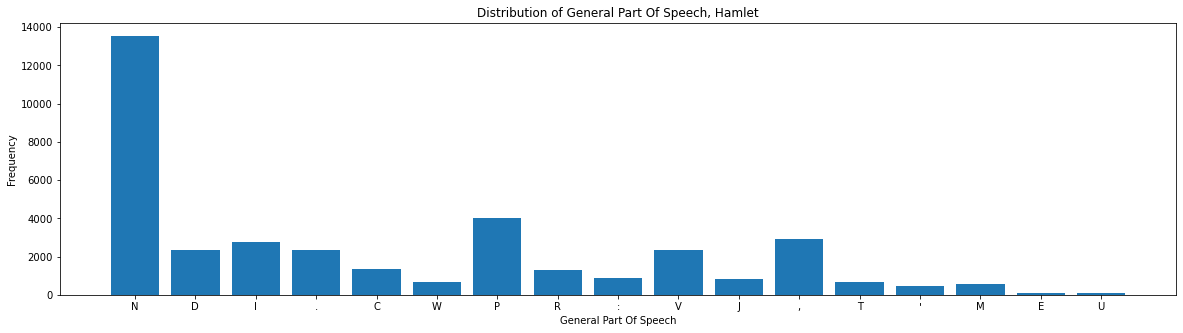

In [34]:
fig = plt.figure(figsize = (20, 5))
plt.bar(hamlet_tag_classes_fd.keys(), hamlet_tag_classes_fd.values())
plt.ylabel('Frequency')
plt.xlabel('General Part Of Speech')
plt.title('Distribution of General Part Of Speech, Hamlet')